# Environment setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Colab\ Notebooks/ECE219/Project\ 4

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/ECE219/Project 4


# Utils

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import datetime
import matplotlib.pyplot as plt

In [3]:
!!pip install scikit-learn==1.4

['Collecting scikit-learn==1.4',
 '  Downloading scikit_learn-1.4.0-1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)',
 '\x1b[?25l     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.0/12.1 MB\x1b \x1b?\x1b eta \x1b-:--:--\x1b',
 '\x1b[2K     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.0/12.1 MB\x1b \x1b1.0 MB/s\x1b eta \x1b0:00:12\x1b',
 '\x1b[2K     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.1/12.1 MB\x1b \x1b2.0 MB/s\x1b eta \x1b0:00:07\x1b',
 '\x1b[2K     \x1b━\x1b\x1b╺\x1b\x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.4/12.1 MB\x1b \x1b3.5 MB/s\x1b eta \x1b0:00:04\x1b',
 '\x1b[2K     \x1b━\x1b\x1b╸\x1b\x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.5/12.1 MB\x1b \x1b3.9 MB/s\x1b eta \x1b0:00:03\x1b',
 '\x1b[2K     \x1b━━━━\x1b\x1b╸\x1b\x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b1.4/12.1 MB\x1b \x1b7.5 MB/s\x1b eta \x1b0:00:02\x1b',
 '\x1b[2K     \x1b━━━━━\x1b\x1b╸\x1b\x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b1

In [95]:
from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.metrics import ConfusionMatrixDisplay

In [5]:
!pip install transformers
!pip install lightgbm

In [6]:
!pip install torchinfo
from torchinfo import summary

In [7]:
from transformers import pipeline

In [8]:
from tqdm.auto import tqdm

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from torch.optim import Adam

import torch.nn.functional as F

In [10]:
import lightgbm as lgb

In [11]:
import pytz

def timezone_convert(unix_time, location='America/Los_Angeles'):
    pst_tz = pytz.timezone(location)
    return datetime.datetime.fromtimestamp(unix_time, pst_tz)

In [12]:
def data_analysis(dir_path, tweet_filename, verbose=True):
    """
    Return the following statistics in the corresponding file:
    - Average number of tweets per hour
    - Average number of followers of users posting the tweets per tweet
    - Average number of retweets per tweet
    """
    num_tweets, num_tweets_per_hour = 0, {}                         # distinguish between the same hour across different days
    num_followers, num_retweets = 0, 0

    file_path = os.path.join(dir_path, tweet_filename)
    with open(file_path, 'r') as f:
        for line in f:
            # load the whole tweet string
            curr_tweet = json.loads(line)
            # handle the number of tweets per hour
            num_tweets += 1
            curr_time = timezone_convert(curr_tweet['citation_date'])
            curr_day_hour = (curr_time.date(), curr_time.hour)              # tuple of (day, hour)
            if curr_day_hour not in num_tweets_per_hour:
                num_tweets_per_hour[curr_day_hour] = 0
            num_tweets_per_hour[curr_day_hour] += 1
            # load the followers of the user posting this tweet
            num_followers += curr_tweet['author']['followers']
            # load the retweets
            num_retweets += curr_tweet['metrics']['citations']['total']
    avg_tweets_per_hour = num_tweets / len(num_tweets_per_hour)
    avg_followers = num_followers / num_tweets
    avg_retweets = num_retweets / num_tweets
    if verbose:
        hashtag = tweet_filename.split("_")[-1].split(".")[0]
        print(f"The average number of tweets per hour for {hashtag} is {avg_tweets_per_hour} spanning {len(num_tweets_per_hour)} hours.")
        print(f"The average number of followers of users posting the tweets per tweet for {hashtag} is {avg_followers}.")
        print(f"The average number of retweets per tweet for {hashtag} is {avg_retweets}")
    return avg_tweets_per_hour, avg_followers, avg_retweets, num_tweets_per_hour


def plot_per_day(num_tweets_per_hour, hashtag):
    # plot the number of tweets per day for clear visualization
    num_tweets_per_day = {}
    for time_pair in num_tweets_per_hour:
        day, hour = time_pair
        if day not in num_tweets_per_day:
            num_tweets_per_day[day] = 0
        num_tweets_per_day[day] += num_tweets_per_hour[time_pair]

    days = sorted(list(num_tweets_per_day.keys()))
    counts = [num_tweets_per_day[day] for day in days]
    plt.bar(days, counts)
    plt.xlabel('Date')
    plt.ylabel('Tweet count')
    plt.title(f'Number of tweets in days for {hashtag}')
    plt.xticks(rotation=45)         # Rotate days for better readibility
    plt.tight_layout()
    plt.show()

# Data analysis

In [13]:
data_path = "./data/tweet_data"

In [ ]:
tag_filenames = os.listdir(data_path)           # all the text files under data_path

# report the statistics
for tag_filename in tag_filenames:
    data_analysis(data_path, tag_filename)
    print('-' * 100)

The average number of tweets per hour for #nfl is 399.69468267581476 spanning 583 hours.
The average number of followers of users posting the tweets per tweet for #nfl is 4662.37544523693.
The average number of retweets per tweet for #nfl is 1.5344602655543254
----------------------------------------------------------------------------------------------------
The average number of tweets per hour for #superbowl is 2067.824531516184 spanning 587 hours.
The average number of followers of users posting the tweets per tweet for #superbowl is 8814.96799424623.
The average number of retweets per tweet for #superbowl is 2.3911895819207736
----------------------------------------------------------------------------------------------------
The average number of tweets per hour for #sb49 is 1384.8212290502793 spanning 537 hours.
The average number of followers of users posting the tweets per tweet for #sb49 is 10374.160292019487.
The average number of retweets per tweet for #sb49 is 2.5271344411

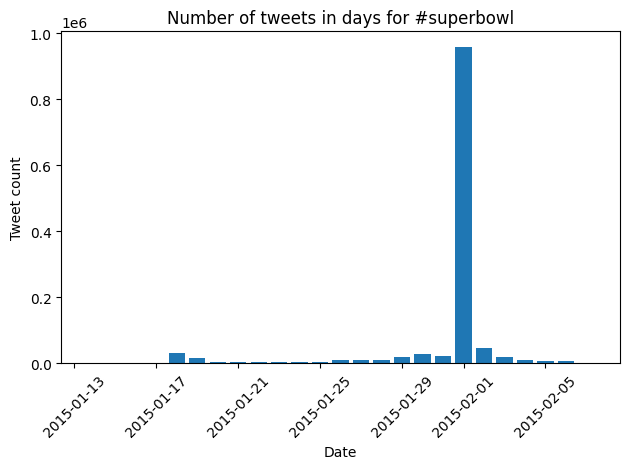

In [ ]:
num_tweets_per_hour_superbowl = data_analysis(data_path, 'tweets_#superbowl.txt', verbose=False)[-1]
plot_per_day(num_tweets_per_hour_superbowl, "#superbowl")

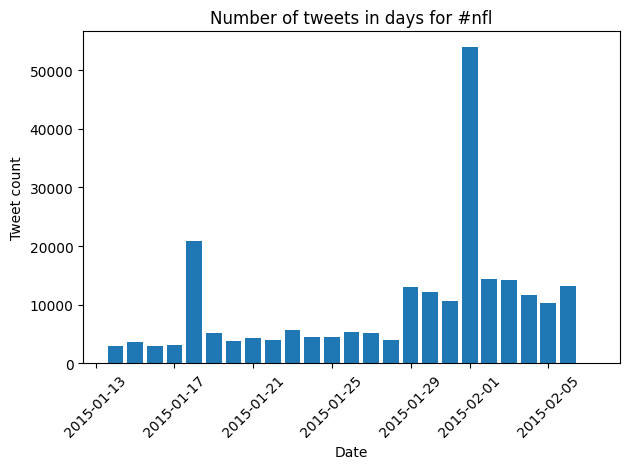

In [ ]:
num_tweets_per_hour_nfl = data_analysis(data_path, 'tweets_#nfl.txt', verbose=False)[-1]
plot_per_day(num_tweets_per_hour_nfl, "#nfl")

# Custom Task

In the below part, I performed three predicton tasks given the corresponding raw tweet text:
- classify the fan class of the user posting the tweet
- predict the number of retweets of a tweet
- predict the number of likes of a tweet

The first task is organized under `Classification`, the second and third are both included under `Regression`. 

The sections `Data load`, `Data clean`, `Feature engineering` were used to obtain different features for the raw tweet text.

# Data load 

For the purpose of customed tasks, we extract the data from the following files:
- `tweets_#gohawks.txt`
- `tweets_#gopatriots.txt`

Given the fact that the tweets with `#gohawks` were many more than those with `#gopatriots`, we sample from `tweets_#gohawks.txt` to maintain class balanced.

In [127]:
def load_tweets(dir_path, tweet_filename):
    """
    Returns the tweets in the given path where each tweet string is a JSON object.
    We need the columns "text", "fan", "retweets", "likes"
    """
    tweet_info = []
    hashtag = tweet_filename.split("_")[-1].split(".")[0][1:]

    file_path = os.path.join(dir_path, tweet_filename)
    with open(file_path, 'r') as f:
        for line in f:
            # load the whole tweet string and collect the needed columns
            curr_tweet = json.loads(line)
            curr_dict = {}
            curr_dict["text"] = curr_tweet["tweet"]["text"]
            curr_dict["fan"] = hashtag
            curr_dict["retweets"] = curr_tweet['metrics']['citations']['total']
            curr_dict["likes"] = curr_tweet["tweet"]["favorite_count"]
            tweet_info.append(curr_dict)
    return pd.DataFrame(tweet_info)

In [128]:
sample_size = 5000

patriots = load_tweets(data_path, "tweets_#gopatriots.txt")
hawks = load_tweets(data_path, "tweets_#gohawks.txt").sample(n=len(patriots), random_state=42)
full_data = pd.concat([patriots, hawks], axis=0).sample(n=sample_size)            # sub-sample here
print(f"The shape of full data is {full_data.shape}")

The shape of full data is (5000, 4)


In [ ]:
patriots.head()

,text,fan,retweets,likes
0,LeGarrette Blount does the Ray Lewis Dance #Th...,gopatriots,6,0
1,Y así será mi futuro hijo 😍🙌❤🏈💙 #GoPatriots #M...,gopatriots,4,0
2,With both my father and husband yelling at the...,gopatriots,3,0
3,The girls soccer team is ranked the No. 3 team...,gopatriots,3,1
4,@patriots Patriots Champions! RT if you agree ...,gopatriots,2,0


In [ ]:
hawks.head()

,text,fan,retweets,likes
134889,INTERCEPTION! Hope #Lane is ok! #GoHawks,gohawks,1,0
153226,Relationship goals 😍 #GoHawks http://t.co/FLdU...,gohawks,3,0
129121,#BeastMode #GoHawks,gohawks,3,0
111062,Nervous and excited for the game. Go Hawks!!! ...,gohawks,1,0
12732,Even Tyson knows whath up! Lol #GoHawks http:/...,gohawks,1,0


In [ ]:
patriots['likes'].describe()

count    23511.000000
mean         0.019608
std          0.466667
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         60.000000
Name: likes, dtype: float64

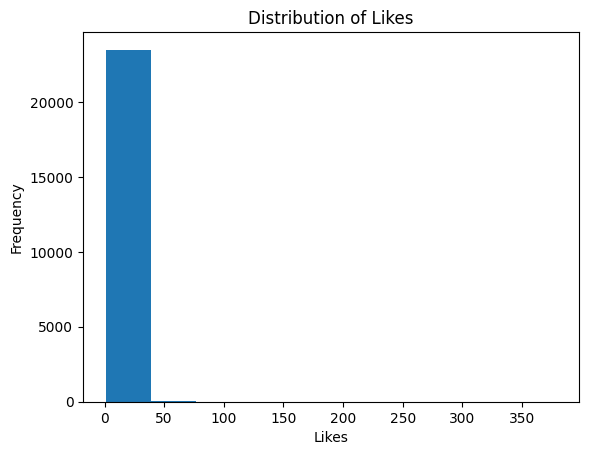

In [ ]:
plt.hist(patriots['retweets'])
plt.title('Distribution of Likes')
plt.xlabel('Likes')
plt.ylabel('Frequency')
plt.show()

# Data clean

The original tweet texts are very messy, and also contain the hashtags that we might want to predict. We need a full clean for the text so that they can be further used as features.

1. Remove any hashtag and mention from the raw text, as those have too high correlation with the target.
2. Remove any html element like urls which cannot be well embedded and meaningless.

Experiments showed that the lemmatization is too strong for tweet text, so I did not apply it for further training.

We also want to remove the empty rows that have empty text or only spaces, which may influence the model learning.

In [ ]:
def count_alnum(s):
    return sum(c.isalnum() for c in s)

import re
def clean(text):
    text = re.sub(r'https?:\/\/\S+', '', text)              # remove the urls
    text = re.sub(r'#\w+', '', text)                        # remove the hashtags
    text = re.sub(r'@\w+', '', text)                        # remove the mentions
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter


def exclude_empty_row(dataframe, target_column):
    """
    Remove the rows that have empty text, which may influence the model learning.
    """
    return dataframe[dataframe[target_column].str.strip().ne('')]

In [ ]:
full_data["text"] = full_data["text"].apply(clean)
full_data_clean = exclude_empty_row(full_data, "text")

In [ ]:
full_data_clean.head()

,text,fan,retweets,likes
16903,Qu les pasa a los Patriotas?,gopatriots,1,0
11788,\o/,gopatriots,1,0
30200,We must be on a date dash or something @,gohawks,1,0
11502,Edelman is the man!,gopatriots,1,0
16081,Best halftime show ever!,gopatriots,1,0


In [ ]:
patriots["text"] = patriots["text"].apply(clean)
patriots_clean = exclude_empty_row(patriots, "text")

hawks["text"] = hawks["text"].apply(clean)
hawks_clean = exclude_empty_row(hawks, "text")

In [ ]:
patriots_clean.head(10)

,text,fan,retweets,likes
0,LeGarrette Blount does the Ray Lewis Dance Hop...,gopatriots,6,0
1,Y as ser mi futuro hijo,gopatriots,4,0
2,With both my father and husband yelling at the...,gopatriots,3,0
3,The girls soccer team is ranked the No. 3 team...,gopatriots,3,1
4,Patriots Champions! RT if you agree ;),gopatriots,2,0
5,12-0! The girls varsity soccer team dominates ...,gopatriots,6,2
6,thanks for the follow!,gopatriots,2,0
7,: which team do you follow? who do you want to...,gopatriots,4,0
8,Reminder - Old HomeBase Bell Schedule today/to...,gopatriots,3,0
10,Can't wait to watch the Super Bowl of this sea...,gopatriots,1,0


In [ ]:
hawks_clean.head(10)

,text,fan,retweets,likes
134889,INTERCEPTION! Hope is ok!,gohawks,1,0
153226,Relationship goals,gohawks,3,0
111062,Nervous and excited for the game. Go Hawks!,gohawks,1,0
12732,Even Tyson knows whath up! Lol,gohawks,1,0
137674,This feels a lot like the Green Bay game.,gohawks,1,0
153828,Os receiver dos Patriots foram treinados pelo ...,gohawks,1,0
159944,: aww cute family,gohawks,1,0
76091,Check out our new Hawks shirts! Go Hawks!,gohawks,1,0
135962,You see Brady after that hit and interception!...,gohawks,1,0
27434,Let's go Seahawks!,gohawks,1,0


# Feature engineering

We have two methods for feature engineering: GLoVE and BERT. Considering the numtiliugual nature of tweet texts, we need to do necessary translation.

For GLoVE, as the embeddings were trained on the English corpus, the best solution is to use a translator(e.g., Romance-to-English translator) before feeding the features into the GLoVE encoder. I tried the following code below:
```
romance_translator = pipeline("translation", model="Helsinki-NLP/opus-mt-ROMANCE-en")

def translate(translator, text):
    # return a sequence of translated text
    translations = translator(text, max_length=512)
    results = []
    for i in tqdm(range(len(translations))):
        translation = translations[i]
        results.append(translation['translation_text'])
    return results
```
However, the dataset is too large for a reasonable translation. Alternatively, I (automatically) exclude those non-English texts as they may not be included inside the GLoVE pre-trained embeddings.

For BERT, there is a pre-trained multi-lingual BERT `mBERT` available in huggingface, which can be used for encoding the text.

## GLoVE embeddings

### Lemmatization

GLoVE is a relatively week encoder for text. To accomodate to its conditions, I need to select the tweets written in English and make lemmatization converion on the text.

The cleaned text after lemmatization is in `full_data_lemma`.

In [ ]:
import nltk
from nltk import sent_tokenize, word_tokenize, pos_tag
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction import text

from string import punctuation

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words_skt = text.ENGLISH_STOP_WORDS
stop_words_en = stopwords.words('english')
combined_stopwords = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))
# print("#(stop_words_skt): {}".format(len(stop_words_skt)))
# print("#(stop_words_en): {}".format(len(stop_words_en)))
# print("#(punctuation): {}".format(len(punctuation)))
# print("#(combined_stopwords): {}".format(len(combined_stopwords)))

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN             # this will be used on unrecognized tags


def lemma_convert(text):
    sentences = sent_tokenize(text)                 # break a text into sentences
    results = []
    for sentence in sentences:
        curr_result = []
        sen_tokens = word_tokenize(sentence)        # break a sentence into tokens
        word_tag_tokens = pos_tag(sen_tokens)       # find pos_tag for each word token
        # lemmatize each word token using its pos_tag and concatenate back to a lemmatized sentence
        for word, tag in word_tag_tokens:
            lemma_word = lemmatizer.lemmatize(word=word.lower(), pos=get_wordnet_pos(tag))
            if lemma_word not in combined_stopwords and not lemma_word.isdigit():           # filter out digits and stopwords
                curr_result.append(lemma_word)
        results.append(' '.join(curr_result))
    return ' '.join(results)

In [ ]:
full_data_lemma = full_data_clean.copy()
full_data_lemma["text"] = full_data_lemma["text"].apply(lemma_convert)

In [ ]:
full_data_lemma.head()

,text,fan,retweets,likes
148411,17-14,gohawks,1,0
93977,today 's super bowl drink special 2.12 mvp,gohawks,1,0
6529,let 's ...,gopatriots,1,0
15580,`` trend uk:01:00 gmt '' american football ...,gopatriots,1,0
8778,ya estoy lista para el sper bowl,gopatriots,1,0


### GLoVE encoding

In [ ]:
def collect_GLoVE_dict(file_path):
    embeddings_dict = {}
    with open(file_path, 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector
    return embeddings_dict

GLoVE_dict_300 = collect_GLoVE_dict("glove/glove.6B.300d.txt")

In [ ]:
import ast

def normalization(vector):
    norm = np.linalg.norm(vector)
    return vector / norm if norm != 0 else vector

def normalized_mean_embeddings(text, embeddings_dict, dim=300, mode="text"):
    if mode == "text":
        word_lst = text.split()
    else:                   # a string of "a list of string"
        word_lst = ast.literal_eval(text)

    embeddings = []
    for word in word_lst:
        if word in embeddings_dict:
            embeddings.append(normalization(embeddings_dict[word]))
    # in case no word is recognized
    if len(embeddings) == 0:
        return np.zeros(dim)
    return np.mean(embeddings, axis=0)

def final_GLoVE_embeddings(X_clean, GLoVE_dict):
    X_GLoVE_text = np.stack(X_clean.apply(lambda x: normalized_mean_embeddings(x, GLoVE_dict))[:].values, axis=0)
    return X_GLoVE_text

In [ ]:
y_fan, y_classes = pd.factorize(full_data_lemma["fan"])
X_lemma = final_GLoVE_embeddings(full_data_lemma["text"], GLoVE_dict_300)
print(f"The GLoVE features for training text has shape {X_lemma.shape} and labels have shape {y_fan.shape}")

The GLoVE features for training text has shape (4410, 300) and labels have shape (4410,)


Notice that some tweets may be written in non-English, or it is somehow meaningless over GLoVE. As a result, we must exclude them from the training data.

In [ ]:
meaningful_idx = np.where(np.all(X_lemma != 0, axis=1))[0]
X_lemma_meaningful = X_lemma[meaningful_idx]
y_lemma_meaningful = y_fan[meaningful_idx]
print(f"The meainingful GLoVE features for training text has shape {X_lemma_meaningful.shape} and labels have shape {y_lemma_meaningful.shape}")

The meainingful GLoVE features for training text has shape (4152, 300) and labels have shape (4152,)


In [ ]:
retweet_lemma_meaningful = full_data_lemma["retweets"].iloc[meaningful_idx].tolist()
likes_lemma_meaningful = full_data_lemma["likes"].iloc[meaningful_idx].tolist()

In [ ]:
np.savez('GLoVE_data.npz',
         text=X_lemma_meaningful,
         fan=y_lemma_meaningful,
         retweets=np.array(retweet_lemma_meaningful),
         likes=np.array(likes_lemma_meaningful))

## LLM pre-trained encoder: mBERT

In [ ]:
from transformers import BertModel, BertTokenizer

# load the pre-trained model from
mbert_name = 'bert-base-multilingual-cased'
mbert_tokenizer = BertTokenizer.from_pretrained(mbert_name)
mbert_model = BertModel.from_pretrained(mbert_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [ ]:
inputs = mbert_tokenizer(full_data_clean["text"].tolist(), return_tensors="pt", padding=True, truncation=True, max_length=512)
with torch.no_grad():
    outputs = mbert_model(**inputs)

X_mbert = outputs.pooler_output
# y_fan is generated in GLoVE

In [ ]:
print(f"The m-BERT features for training text has shape {(X_mbert.size(0), X_mbert.size(1))} and labels have shape {y_fan.shape}")

The m-BERT features for training text has shape (4410, 768) and labels have shape (4410,)


In [ ]:
retweet_clean = full_data_clean["retweets"].tolist()
likes_clean = full_data_clean["likes"].tolist()

In [ ]:
# the m-BERT model is very large on RAM, so store the encoded features for later load
np.savez('mBERT_data.npz',
         text=X_mbert.numpy(),
         fan=y_fan,
         retweets=np.array(retweet_clean),
         likes=np.array(likes_clean))

## Result features

We can load the data for next step here. Notice that the two datasets have different sizes, due to the strength of cleaning for different encoders.

Also, `y_classes = Index(['gohawks', 'gopatriots'], dtype='object')`, indicating that 0 refers to "hawks", and 1 refers to "patriots".

In [86]:
with np.load('GLoVE_data.npz') as data:
    X_GLoVE = data["text"]
    y_GLoVE = data["fan"]
    retweets_GLoVE = data["retweets"]
    likes_GLoVE = data["likes"]

In [87]:
with np.load('mBERT_data.npz') as data:
    X_mBERT = data["text"]
    y_mBERT = data["fan"]
    retweets_mBERT = data["retweets"]
    likes_mBERT = data["likes"]

A brief look at the target distribution (take the more complete data from m-BERT).

The fan label distribution looks well balanced, but the distribution of retweets and likes both appear extremely right-skewed.

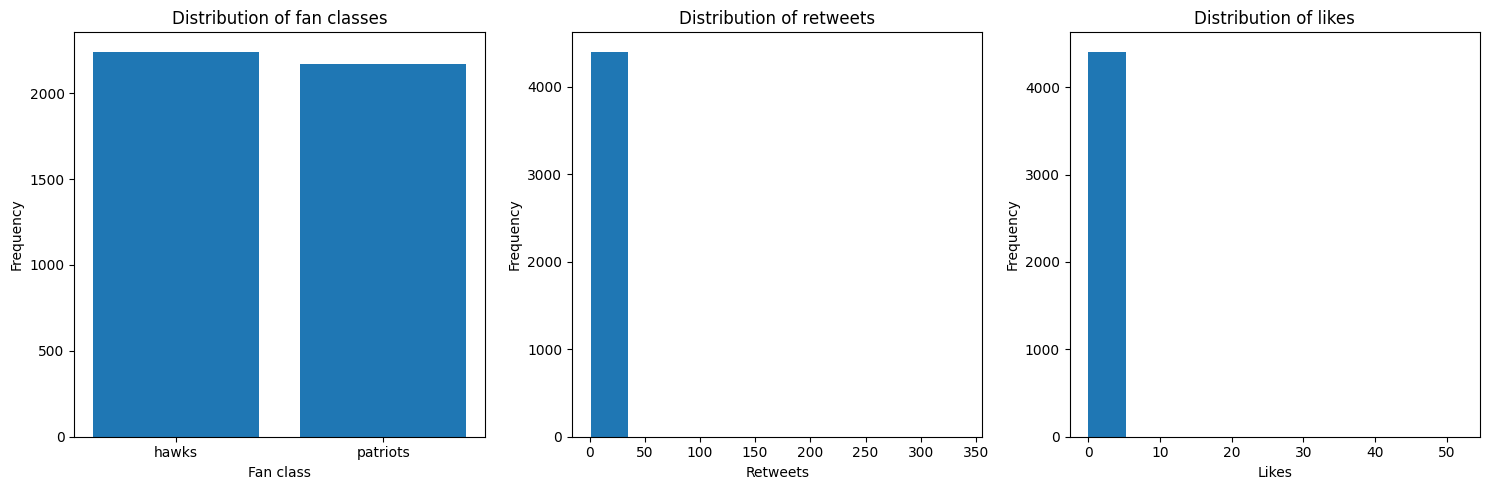

In [88]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
fan_values, fan_counts = np.unique(y_mBERT, return_counts=True)
fan_labels = ["hawks" if val == 0 else "patriots" for val in fan_values]
plt.bar(fan_labels, fan_counts)
plt.title('Distribution of fan classes')
plt.xlabel('Fan class')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(retweets_mBERT)
plt.title('Distribution of retweets')
plt.xlabel('Retweets')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(likes_mBERT)
plt.title('Distribution of likes')
plt.xlabel('Likes')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Training utils



In [92]:
# Simple classifier model
class SCLF(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes=2, dropout_rate=0.5):
        super(SCLF, self).__init__()

        self.input_layer = nn.Linear(in_features, hidden_features[0])

        layers = []
        for i in range(len(hidden_features) - 1):
            layers.append(nn.Linear(hidden_features[i], hidden_features[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
        self.hidden_layers = nn.Sequential(*layers)

        self.output_layer = nn.Linear(hidden_features[-1], num_classes)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layers(x)
        x = self.output_layer(x)                # the probabilities for softmax
        return x

In [93]:
# Simple regressor model
class SR(nn.Module):
    def __init__(self, in_features, hidden_features, dropout_rate=0.5):
        super(SR, self).__init__()

        self.input_layer = nn.Linear(in_features, hidden_features[0])

        layers = []
        for i in range(len(hidden_features) - 1):
            layers.append(nn.Linear(hidden_features[i], hidden_features[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
        self.hidden_layers = nn.Sequential(*layers)

        self.output_layer = nn.Linear(hidden_features[-1], 1)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        x = x.squeeze()                     # to avoid broadcast in loss computation
        return x

In [117]:
def train(model, X, y, criterion, optimizer, num_epochs, batch_size, device):
    # prepare the dataloaders
    X_train, X_val, y_train, y_val = train_test_split(torch.from_numpy(X), torch.from_numpy(y), test_size=0.1, random_state=42)
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=True)

    # for visualization and best_val weights
    best_model_weights = None
    best_val_loss = float("inf")
    train_loss_history, val_loss_history = [], []

    for epoch in tqdm(range(num_epochs)):
        model.train()
        train_loss = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            preds = model(X)
            loss = criterion(preds, y)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        train_loss /= len(train_loader)
        train_loss_history.append(train_loss)

        # compute the val loss
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                preds = model(X_val)
                loss = criterion(preds, y_val)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)
        # possible record
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict().copy()
    return train_loss_history, val_loss_history, best_model_weights


def plot_loss(train_hist, val_hist, title):
    """
    Plot the training and validation loss during the training epochs, showing the convergence.
    """
    plt.plot(train_hist, label='train loss')
    plt.plot(val_hist, label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Val Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


def clf_predict(model, inputs):
    model.to('cpu')
    model.eval()
    with torch.no_grad():
        logits = model(inputs)
        probs = F.softmax(logits, dim=1)
        _, predicted_classes = torch.max(probs, dim=1)
    return predicted_classes


def reg_predict(model, inputs):
    model.to('cpu')
    model.eval()
    with torch.no_grad():
        preds = model(inputs)
    return preds

In [96]:
def result_metrics(model_name, y_true, y_predict, pos_label=1, average='binary'):
    print("Accuracy of {} is {}".format(model_name, accuracy_score(y_true, y_predict)))
    print("Recall of {} is {}".format(model_name, recall_score(y_true, y_predict, pos_label=pos_label, average=average)))
    print("Precision of {} is {}".format(model_name, precision_score(y_true, y_predict, pos_label=pos_label, zero_division=0.0, average=average)))
    print("F-1 score of {} is {}".format(model_name, f1_score(y_true, y_predict, pos_label=pos_label, zero_division=0.0, average=average)))


def regression_metrics(model_name, y_true, y_pred, mape=True):
    print("RMSE of {} is {}".format(model_name, root_mean_squared_error(y_true, y_pred)))
    print("MAE of {} is {}".format(model_name, mean_absolute_error(y_true, y_pred)))
    if mape:        # not meaningful when targets mostly close to 0
        print("MAPE of {} is {}".format(model_name, mean_absolute_percentage_error(y_true, y_pred)))

## Data split

In [107]:
GLoVE_size = X_GLoVE.shape[0]
train_idx_GLoVE, test_idx_GLoVE = train_test_split(np.arange(GLoVE_size), test_size=0.2, random_state=42)

X_train_GLoVE, X_test_GLoVE = X_GLoVE[train_idx_GLoVE], X_GLoVE[test_idx_GLoVE]
y_train_GLoVE, y_test_GLoVE = y_GLoVE[train_idx_GLoVE], y_GLoVE[test_idx_GLoVE]
retweets_train_GLoVE, retweets_test_GLoVE = retweets_GLoVE[train_idx_GLoVE], retweets_GLoVE[test_idx_GLoVE]
likes_train_GLoVE, likes_test_GLoVE = likes_GLoVE[train_idx_GLoVE], likes_GLoVE[test_idx_GLoVE]

In [108]:
mBERT_size = X_mBERT.shape[0]
train_idx_mBERT, test_idx_mBERT = train_test_split(np.arange(mBERT_size), test_size=0.2, random_state=42)

X_train_mBERT, X_test_mBERT = X_mBERT[train_idx_mBERT], X_mBERT[test_idx_mBERT]
y_train_mBERT, y_test_mBERT = y_mBERT[train_idx_mBERT], y_mBERT[test_idx_mBERT]
retweets_train_mBERT, retweets_test_mBERT = retweets_mBERT[train_idx_mBERT], retweets_mBERT[test_idx_mBERT]
likes_train_mBERT, likes_test_mBERT = likes_mBERT[train_idx_mBERT], likes_mBERT[test_idx_mBERT]

# Classification

In this task, we want to predict the specific fan class that a tweet belongs to.

Since the target classes are well balanced, I directly performed the classification.

The data we need:
- GLoVE:
    - `X_train_GLoVE`, `X_test_GLoVE`
    - `y_train_GLoVE`, `y_test_GLoVE`
- mBERT:
    - `X_train_mBERT`, `X_test_mBERT`
    - `y_train_mBERT`, `y_test_mBERT`

## Baselines: Bayes, SVM

In [109]:
# Bayes classifier
bayes = GaussianNB()
bayes.fit(X_train_GLoVE, y_train_GLoVE)

result_metrics("Bayes classifier on GLoVE", y_test_GLoVE, bayes.predict(X_test_GLoVE))

Accuracy of Bayes classifier on GLoVE is 0.6486161251504212
Recall of Bayes classifier on GLoVE is 0.5112219451371571
Precision of Bayes classifier on GLoVE is 0.6810631229235881
F-1 score of Bayes classifier on GLoVE is 0.584045584045584


In [110]:
# hard SVM
SVM = SVC(C=1e3, kernel="linear")
SVM.fit(X_train_GLoVE, y_train_GLoVE)

result_metrics("SVM classifier on GLoVE", y_test_GLoVE, SVM.predict(X_test_GLoVE))

Accuracy of SVM classifier on GLoVE is 0.690734055354994
Recall of SVM classifier on GLoVE is 0.5960099750623441
Precision of SVM classifier on GLoVE is 0.7155688622754491
F-1 score of SVM classifier on GLoVE is 0.6503401360544218


## Logistic classifier on GLoVE

In [111]:
# Logistic classifier
logistic_classifier = LogisticRegression(penalty='l2', C=1e3, solver="liblinear")
logistic_classifier.fit(X_train_GLoVE, y_train_GLoVE)

result_metrics("Logistic classifier on GLoVE", y_test_GLoVE, logistic_classifier.predict(X_test_GLoVE))

Accuracy of Logistic classifier on GLoVE is 0.7051744885679904
Recall of Logistic classifier on GLoVE is 0.6309226932668329
Precision of Logistic classifier on GLoVE is 0.7228571428571429
F-1 score of Logistic classifier on GLoVE is 0.6737683089214381


## LightGBM on GLoVE

In [112]:
lgb_clf = lgb.LGBMClassifier(max_depth=10,
                             objective="binary",      # binary task
                             reg_lambda=1e-3,         # prevent overfit
                             reg_alpha=1e-3,
                             n_estimators=150,
                             learning_rate=1e-1,
                             verbose=-1,
                             random_state=42)
lgb_clf.fit(X_train_GLoVE, y_train_GLoVE)

result_metrics("LightGBM classifier on GLoVE", y_test_GLoVE, lgb_clf.predict(X_test_GLoVE))

Accuracy of LightGBM classifier on GLoVE is 0.7196149217809867
Recall of LightGBM classifier on GLoVE is 0.6408977556109726
Precision of LightGBM classifier on GLoVE is 0.7427745664739884
F-1 score of LightGBM classifier on GLoVE is 0.6880856760374833


## Simple Neural Classifier on m-BERT

Previous experiments showed that the models works well on the GLoVE embeddings. However, all of them performed worse on the mBERT-encoded features. I want to check whether a neural network can utilize the mBERT features well.

In [115]:
summary(SCLF(768, [512, 128, 32]), (64, 768))

Layer (type:depth-idx)                   Output Shape              Param #
SCLF                                     [64, 2]                   --
├─Linear: 1-1                            [64, 512]                 393,728
├─Sequential: 1-2                        [64, 32]                  --
│    └─Linear: 2-1                       [64, 128]                 65,664
│    └─ReLU: 2-2                         [64, 128]                 --
│    └─Dropout: 2-3                      [64, 128]                 --
│    └─Linear: 2-4                       [64, 32]                  4,128
│    └─ReLU: 2-5                         [64, 32]                  --
│    └─Dropout: 2-6                      [64, 32]                  --
├─Linear: 1-3                            [64, 2]                   66
Total params: 463,586
Trainable params: 463,586
Non-trainable params: 0
Total mult-adds (M): 29.67
Input size (MB): 0.20
Forward/backward pass size (MB): 0.35
Params size (MB): 1.85
Estimated Total Size (MB): 2.40

In [119]:
mBERT_DIM = 768
weight_decay=1e-2
learning_rate = 2e-5
hidden_dims = [256, 128, 64]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SCLF(mBERT_DIM, hidden_dims).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_hist, val_hist, best_weights = train(model=model,
                                           X=X_train_mBERT,
                                           y=y_train_mBERT,
                                           criterion=criterion,
                                           optimizer=optimizer,
                                           num_epochs=300,
                                           batch_size=64,
                                           device=device)

  0%|          | 0/300 [00:00<?, ?it/s]

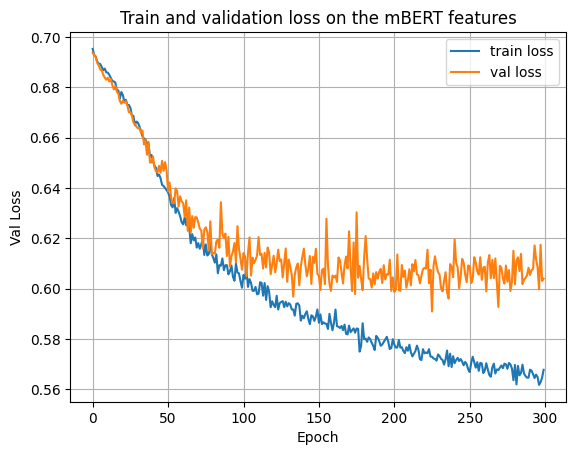

In [120]:
plot_loss(train_hist, val_hist, "Train and validation loss on the mBERT features")

In [125]:
model.load_state_dict(best_weights)
y_predict_test = clf_predict(model, torch.from_numpy(X_test_mBERT))

result_metrics("Neural network classifier on mBERT", y_test_mBERT, y_predict_test)

Accuracy of Neural network classifier on mBERT is 0.671201814058957
Recall of Neural network classifier on mBERT is 0.6261261261261262
Precision of Neural network classifier on mBERT is 0.6915422885572139
F-1 score of Neural network classifier on mBERT is 0.6572104018912529


## Results

From the evaluations above, we can see that the Logistic classifier and lightGBM classifer both outperformed the baseline models on the GLoVE features.

Besides, a simple neural network can perform fairly well on the m-BERT encoded features, while other extra experiments showed that other models could not work well with m-BERT encoded features. One explanation can be that those models could not divide m-BERT features of high dimension.

# Regression

## Predict tweets

We already showed that the retweets have a very extreme right-skewed distribution.

The data we need will be:
- GLoVE:
    - `X_train_GLoVE`, `X_test_GLoVE`
    - `retweets_train_GLoVE`, `retweets_test_GLoVE`
- mBERT:
    - `X_train_mBERT`, `X_test_mBERT`
    - `retweets_train_mBERT`, `retweets_test_mBERT`

Below I listed the description of "retweets" in the full data.

In [130]:
full_data['retweets'].describe()

count    5000.000000
mean        1.632000
std         8.309102
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       481.000000
Name: retweets, dtype: float64

First, we want to see the performance directly on the data without any transformation on the target variable.

### Baselines: Linear Regression with L2-regularization

In [131]:
l2_regressor = Ridge(alpha=1e2, fit_intercept=True)
l2_regressor.fit(X_train_GLoVE, retweets_train_GLoVE)

regression_metrics("Ridge on GLoVE for retweet", retweets_test_GLoVE, l2_regressor.predict(X_test_GLoVE))

RMSE of Ridge on GLoVE for retweet is 5.9630976982315085
MAE of Ridge on GLoVE for retweet is 0.994083712773189
MAPE of Ridge on GLoVE for retweet is 0.5177972389099841


### LightGBM on GLoVE

In [136]:
lgb_reg = lgb.LGBMRegressor(max_depth=10,
                            objective="regression",
                            reg_lambda=1e-3,         # prevent overfit
                            reg_alpha=1e-3,
                            n_estimators=200,
                            learning_rate=1e-1,
                            verbose=-1,
                            random_state=42)
lgb_reg.fit(X_train_GLoVE, retweets_train_GLoVE)

regression_metrics("LightGBM regressor on GLoVE for retweet", retweets_test_GLoVE, lgb_reg.predict(X_test_GLoVE))

RMSE of LightGBM regressor on GLoVE for retweet is 6.375175416052872
MAE of LightGBM regressor on GLoVE for retweet is 1.41932456183091
MAPE of LightGBM regressor on GLoVE for retweet is 0.8727249807828152


In [137]:
lgb_reg = lgb.LGBMRegressor(max_depth=10,
                            objective="regression",
                            reg_lambda=1e-3,         # prevent overfit
                            reg_alpha=1e-3,
                            n_estimators=200,
                            learning_rate=1e-1,
                            verbose=-1,
                            random_state=42)
lgb_reg.fit(X_train_mBERT, retweets_train_mBERT)

regression_metrics("LightGBM regressor on m-BERT for retweet", retweets_test_mBERT, lgb_reg.predict(X_test_mBERT))

RMSE of LightGBM regressor on m-BERT for retweet is 3.428305571205111
MAE of LightGBM regressor on m-BERT for retweet is 1.3150557014333228
MAPE of LightGBM regressor on m-BERT for retweet is 0.9485290148844248


### Log-transformation on the retweets

Given the target values have a majority of 1's and high right-skew, we appled a log-transformation on the target to solve the rigght-skew. In particular, the transformation is $$y' = \log(y+1)$$
where the additional constant 1 is to avoid having $\log0$.

Thus, we make the reverse transformation when making a prediction $$y = \exp(y')-1$$

In [139]:
lgb_reg = lgb.LGBMRegressor(max_depth=10,
                            objective="regression",
                            reg_lambda=1e-3,         # prevent overfit
                            reg_alpha=1e-3,
                            n_estimators=200,
                            learning_rate=1e-1,
                            verbose=-1,
                            random_state=42)
lgb_reg.fit(X_train_GLoVE, np.log(retweets_train_GLoVE + 1))

regression_metrics("LightGBM regressor on log-transformed GLoVE for retweet", retweets_test_GLoVE, np.exp(lgb_reg.predict(X_test_GLoVE)) - 1)

RMSE of LightGBM regressor on log-transformed GLoVE for retweet is 5.990275759809008
MAE of LightGBM regressor on log-transformed GLoVE for retweet is 0.8234995410488949
MAPE of LightGBM regressor on log-transformed GLoVE for retweet is 0.31668190283893777


In [143]:
lgb_reg = lgb.LGBMRegressor(max_depth=10,
                            objective="regression",
                            reg_lambda=1e-3,         # prevent overfit
                            reg_alpha=1e-3,
                            n_estimators=200,
                            learning_rate=1e-1,
                            verbose=-1,
                            random_state=42)
lgb_reg.fit(X_train_mBERT, np.log(retweets_train_mBERT + 1))

regression_metrics("LightGBM regressor on log-transformed m-BERT for retweet", retweets_test_mBERT, np.exp(lgb_reg.predict(X_test_mBERT)) - 1)

RMSE of LightGBM regressor on log-transformed m-BERT for retweet is 2.148781126837415
MAE of LightGBM regressor on log-transformed m-BERT for retweet is 0.6536555340474074
MAPE of LightGBM regressor on log-transformed m-BERT for retweet is 0.31185435114593674


### Simple Neural Regressor on m-BERT

In [141]:
summary(SR(768, [512, 128, 32]), (64, 768))

Layer (type:depth-idx)                   Output Shape              Param #
SR                                       [64]                      --
├─Linear: 1-1                            [64, 512]                 393,728
├─Sequential: 1-2                        [64, 32]                  --
│    └─Linear: 2-1                       [64, 128]                 65,664
│    └─ReLU: 2-2                         [64, 128]                 --
│    └─Dropout: 2-3                      [64, 128]                 --
│    └─Linear: 2-4                       [64, 32]                  4,128
│    └─ReLU: 2-5                         [64, 32]                  --
│    └─Dropout: 2-6                      [64, 32]                  --
├─Linear: 1-3                            [64, 1]                   33
Total params: 463,553
Trainable params: 463,553
Non-trainable params: 0
Total mult-adds (M): 29.67
Input size (MB): 0.20
Forward/backward pass size (MB): 0.34
Params size (MB): 1.85
Estimated Total Size (MB): 2.40

In [142]:
mBERT_DIM = 768
weight_decay=1e-2
learning_rate = 2e-5
hidden_dims = [256, 128, 32]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SR(mBERT_DIM, hidden_dims).to(device)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_hist, val_hist, best_weights = train(model=model,
                                           X=X_train_mBERT,
                                           y=np.log(retweets_train_mBERT + 1).astype("float32"),
                                           criterion=criterion,
                                           optimizer=optimizer,
                                           num_epochs=300,
                                           batch_size=64,
                                           device=device)

  0%|          | 0/300 [00:00<?, ?it/s]

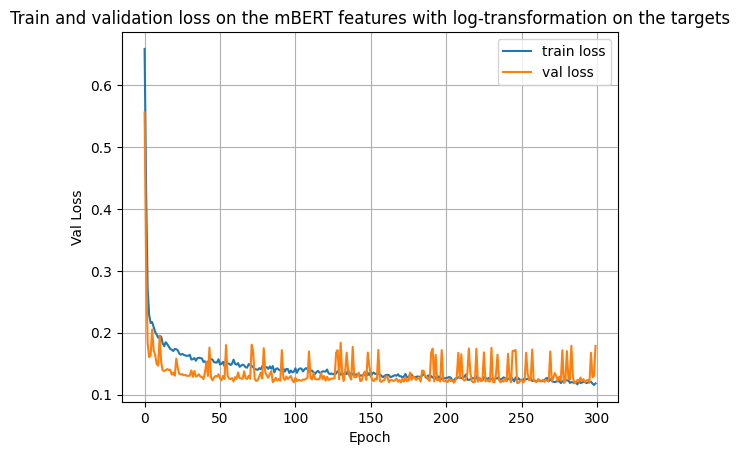

In [144]:
plot_loss(train_hist, val_hist, "Train and validation loss on the mBERT features with log-transformation on the targets")

In [145]:
model.load_state_dict(best_weights)
retweets_predict_test = reg_predict(model, torch.from_numpy(X_test_mBERT))
retweets_predict_test = np.exp(retweets_predict_test) - 1

regression_metrics("Neural network classifier on mBERT", retweets_test_mBERT, retweets_predict_test)

RMSE of Neural network classifier on mBERT is 2.1416967569217795
MAE of Neural network classifier on mBERT is 0.565407524438672
MAPE of Neural network classifier on mBERT is 0.21081016297188035


### Results of predictions on retweets

Based on the results above, we can see that the log-transformation greatly improved the performance of each model, showing the necessity of the appropriate feature engineering.

Besides, models working with the m-BERT encoded features showed better results, which is different from the classification task. This time, the neural network regressor obtained the best performances.

## Predict likes

The distribution of "likes" has the same issue as the "retweets": the extreme right-skewing. As a result, a log-transformation on the target may also help.

One special issue about "likes" is that the majority has value 0 without transformation, making MAPE does not make much sense in this case.



In [146]:
full_data['likes'].describe()

count    5000.000000
mean        0.028800
std         0.368236
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        14.000000
Name: likes, dtype: float64

The data we need will be:
- GLoVE:
    - `X_train_GLoVE`, `X_test_GLoVE`
    - `likes_train_GLoVE`, `likes_test_GLoVE`
- mBERT:
    - `X_train_mBERT`, `X_test_mBERT`
    - `likes_train_mBERT`, `likes_test_mBERT`



### Baseline: Linear Regression with L2-regularization

In [164]:
l2_regressor = Ridge(alpha=1e2, fit_intercept=True)
l2_regressor.fit(X_train_GLoVE, likes_train_GLoVE)

regression_metrics("Ridge on GLoVE for likes", likes_test_GLoVE, l2_regressor.predict(X_test_GLoVE), mape=False)

RMSE of Ridge on GLoVE for likes is 0.24161418794485073
MAE of Ridge on GLoVE for likes is 0.0734601740129802


### LightGBM on GLoVE

In [165]:
lgb_reg = lgb.LGBMRegressor(max_depth=10,
                            objective="regression",
                            reg_lambda=1e-3,         # prevent overfit
                            reg_alpha=1e-3,
                            n_estimators=200,
                            learning_rate=1e-1,
                            verbose=-1,
                            random_state=42)
lgb_reg.fit(X_train_GLoVE, likes_train_GLoVE)

regression_metrics("LightGBM regressor on GLoVE for likes", likes_test_GLoVE, lgb_reg.predict(X_test_GLoVE), mape=False)

RMSE of LightGBM regressor on GLoVE for likes is 0.5752791786052767
MAE of LightGBM regressor on GLoVE for likes is 0.156202206117235


### Log-transformation on the likes

In [166]:
lgb_reg = lgb.LGBMRegressor(max_depth=10,
                            objective="regression",
                            reg_lambda=1e-3,         # prevent overfit
                            reg_alpha=1e-3,
                            n_estimators=200,
                            learning_rate=1e-1,
                            verbose=-1,
                            random_state=42)
lgb_reg.fit(X_train_GLoVE, np.log(likes_train_GLoVE + 1))

regression_metrics("LightGBM regressor on log-transformed GLoVE for likes", likes_test_GLoVE, np.exp(lgb_reg.predict(X_test_GLoVE)) - 1, mape=False)

RMSE of LightGBM regressor on log-transformed GLoVE for likes is 0.25117251747294134
MAE of LightGBM regressor on log-transformed GLoVE for likes is 0.05988331493153209


In [167]:
lgb_reg = lgb.LGBMRegressor(max_depth=10,
                            objective="regression",
                            reg_lambda=1e-3,         # prevent overfit
                            reg_alpha=1e-3,
                            n_estimators=200,
                            learning_rate=1e-1,
                            verbose=-1,
                            random_state=42)
lgb_reg.fit(X_train_mBERT, np.log(likes_train_mBERT + 1))

regression_metrics("LightGBM regressor on log-transformed mBERT for likes", likes_test_mBERT, np.exp(lgb_reg.predict(X_test_mBERT)) - 1, mape=False)

RMSE of LightGBM regressor on log-transformed mBERT for likes is 0.1988293399324899
MAE of LightGBM regressor on log-transformed mBERT for likes is 0.053939177646769094


### Simple Neural Regressor on m-BERT

In [160]:
mBERT_DIM = 768
weight_decay=1e-2

learning_rate = 2e-5
hidden_dims = [256, 128, 32]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SR(mBERT_DIM, hidden_dims).to(device)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_hist, val_hist, best_weights = train(model=model,
                                           X=X_train_mBERT,
                                           y=np.log(likes_train_mBERT + 1).astype("float32"),
                                           criterion=criterion,
                                           optimizer=optimizer,
                                           num_epochs=300,
                                           batch_size=64,
                                           device=device)

  0%|          | 0/300 [00:00<?, ?it/s]

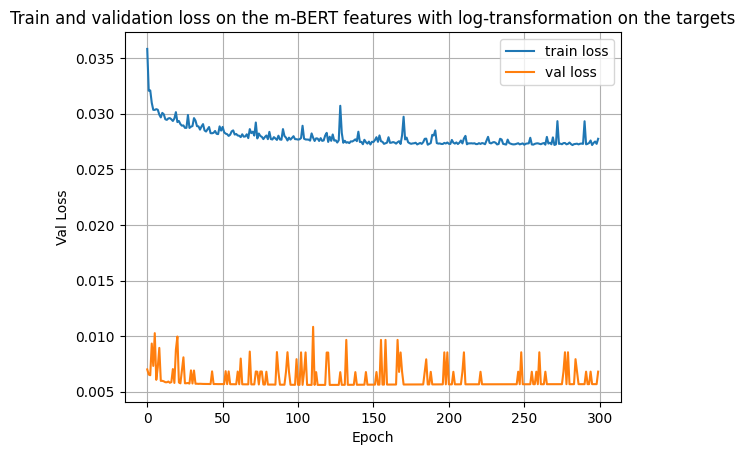

In [161]:
plot_loss(train_hist, val_hist, "Train and validation loss on the m-BERT features with log-transformation on the likes")

In [168]:
model.load_state_dict(best_weights)
y_predict_test = reg_predict(model, torch.from_numpy(X_test_mBERT))
y_predict_test = np.exp(y_predict_test) - 1

regression_metrics("Neural network regressor on log-transformed mBERT for likes", likes_test_mBERT, y_predict_test, mape=False)

RMSE of Neural network regressor on log-transformed mBERT for likes is 0.18708218778632763
MAE of Neural network regressor on log-transformed mBERT for likes is 0.02757983521269022


### Results

Due to the nature of target values (majority is 0), the evaluation of the predictions is not very obvious. However, we can still see that the log-transformation improved the prediction performances.